# Vehicles Categorization with Deep Learning Techniques

In this notebook it is summarized the process from getting the url pictures from [Imagenet](http://image-net.org/) database to the results obtained in vehicles classification for different Deep Learning arquitectures employed. The main goal of this project is to benchmark different and basic neural networks architectures trained in a local machine with limited resources and pictures in the task of vehicles' classification.

### Dataset Wrangling
First step is to retrieve url pictures as [described here](http://image-net.org/download-imageurls) for some of the vehicles categories, a file with all the associated [synsets](https://en.wikipedia.org/wiki/WordNet) is generated and used during the download tasks: ```vehicles_synsets.txt```.

![Alt text](Imagenet_Synsets_cars.png "How to retrieve Synsets from Imagenet")

Since this experiment is performed on a local machine with limited resources (8Gb RAM, 4 CPU cores), only two different vehicles categories will be analyzed:

 1. n04467665: Trailer Trucks
 2. n04285008: Sport-Cars

Following code is employed to download images from urls to a local directory specified in the configuration file: ```configuration.py```:

**IMPORTANT:** Run this code in case you want to locally download pictures.

In [209]:
# imported libraries:

# local scripts:
from scripts import configuration  # includes paths and parameters configurations
from scripts import models # includes the different models
from scripts import Dataset_wrangling # includes scripts from downloading pics to generate datasets

# standard libraries
import os
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from datetime import datetime
import configuration
import pickle
import multiprocessing
import logging
import urllib2
import download_imagenet_images
import pandas
import pickle
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.core.display import HTML,display

print "All required libraries loaded...."

All required libraries loaded....


In [2]:

startTime = datetime.now()
      
# Define local directory to work where file flowers_synsets.txt is included:
local_directory = configuration.path_dataset

# Define logging configuration:
logging.basicConfig(filename = local_directory + 'log_info.log',level=logging.INFO,format='%(asctime)s %(message)s')

# Imagenet path:
imagenet_path = 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid='

# Paralelization, define number of threaths:
max_processes = multiprocessing.cpu_count() - 1

# Get list of wnid to download from local file:
path_to_wnid_file = local_directory + 'vehicles_synsets.txt'
wnid_list = [x.rstrip() for x in open(path_to_wnid_file,'r')]

# Counter to keep track of the number of pictures downloaded per wnid:
Pictures_per_wnid = {}

# Download files for the different wnid:
for wnid in wnid_list:
    try:
        # Get html with pictures http directions for a particular wnid:
        response = urllib2.urlopen(imagenet_path + wnid).read()
    except:
        logging.info('Unable to open url {0}'.format(imagenet_path + wnid))
        print 'Unable to open url {0}'.format(imagenet_path + wnid)
        continue   

    picture_list =  [x for x in response.split("\r\n")]

    # Download pictures:
    counter = 0
    return_list = multiprocessing.Array('i',max_processes)
    jobs = []
    for i,url_pic in enumerate(picture_list):
        inputs = [url_pic, local_directory,'/{0}_{1}'.format(wnid,i)]
        p = multiprocessing.Process(target=download_imagenet_images.worker, args=(inputs,len(jobs),return_list))
        jobs.append(p)
        p.start()
        if len(jobs) == max_processes:
            counter += download_imagenet_images.process_jobs(jobs,return_list)
            return_list = multiprocessing.Array('i',max_processes)
            jobs = []
    if len(jobs) > 0: counter += download_imagenet_images.process_jobs(jobs,return_list)
    Pictures_per_wnid[wnid] = counter
    print "wnid {0} processed with {1} pictures included.\n".format(wnid,counter)

# For debbuging purposes, this variable is stored:
pickle.dump(Pictures_per_wnid, open(local_directory + 'pictures_per_wnid_dict.pickle', "w"))

print 'Script ends, time to complete: {0}'.format(datetime.now() - startTime)



wnid n04467665 processed with 877 pictures included.

wnid n04285008 processed with 721 pictures included.

Script ends, time to complete: 0:19:48.521964


Once all pictures are downloaded in a local directory, function ```sizes_distribution``` from the script: ```Dataset_wrangling.py``` is employed to summarize the number of pictures per category as well as pictures sizes distributions:
**Important:** Run this cell if you downloaded images using the previous script.

In [3]:


# Select path to pictures:
dataset_path = configuration.path_dataset

df_hw = Dataset_wrangling.sizes_distribution(dataset_path)
# Save results in local file
pickle.dump(df_hw, open(dataset_path + 'pictures_summary.pickle', "w"))

Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_810.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_1000.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_465.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_1135.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_789.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_733.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_809.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_112.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5/DeepLearning/Dataset//n04285008/n04285008_36.jpg
Unable to open file /home/rafaelcastillo/MLND/Project5

This is the aspect of the downloaded dataset:

,height,width,channels
count,1550.000000,1550.000000,1550.0
mean,360.367097,500.556129,3.0
std,100.054414,139.935572,0.0
min,1.000000,1.000000,3.0
25%,332.000000,500.000000,3.0
50%,357.000000,500.000000,3.0
75%,375.000000,500.000000,3.0
max,1360.000000,2048.000000,3.0


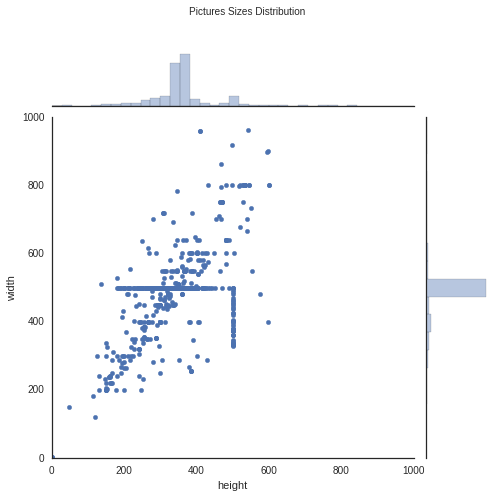

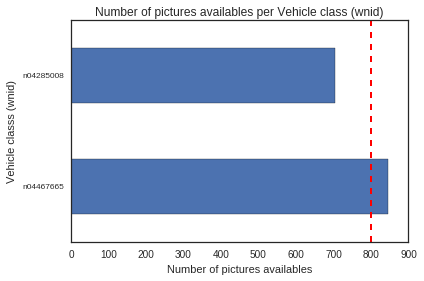

In [9]:

# Load file with the dataset information:
df_hw = pickle.load( open( configuration.path_dataset + 'pictures_summary.pickle', "r" ) )

# Print a summary of the dataset:
display(HTML(df_hw.describe().to_html()))


# Represent Picture sizes distributions:
g=sns.jointplot(df_hw['height'], df_hw['width'], kind="scatter", size=7, stat_func=None,
               xlim=[0,1000], ylim=[0,1000])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Pictures Sizes Distribution')
plt.show()

# Represent number of pictures availables per category
df_hw.groupby('family').count().sort_values('name',ascending=False).loc[:,'name'].plot.barh(legend=None)
plt.ylabel('Vehicle classs (wnid)')
plt.xlabel('Number of pictures availables')
plt.yticks(fontsize='small')
plt.axvline(x=800, linewidth=2, color='red',linestyle='--')
plt.title('Number of pictures availables per Vehicle class (wnid)')
plt.tight_layout()
plt.show()


As shown above, there are a total of 1550 pictures availables with a mean height and width of 352 and 483 pixels respectively and 3 channels (RGB) for the colors. For the different classes, just one of them include more than 800 pictures. 

Next step is to remove those pictures with a relative small size. Since many deep learning models nowadays uses 150px for width and heigth, in this experiment, pictures with smaller dimensions will be removed: 
 

,height,width,channels
count,1532.000000,1532.000000,1532.0
mean,363.196475,503.961488,3.0
std,97.012305,136.624241,0.0
min,152.000000,200.000000,3.0
25%,333.000000,500.000000,3.0
50%,359.000000,500.000000,3.0
75%,375.000000,500.000000,3.0
max,1360.000000,2048.000000,3.0


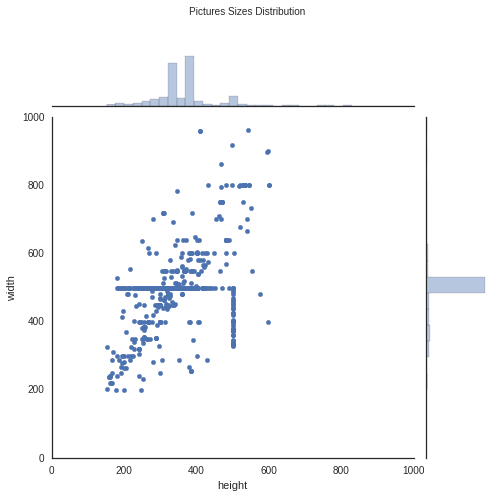

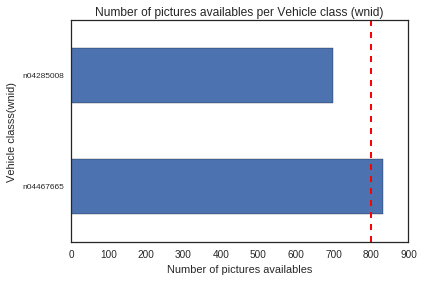

In [10]:

# Get pictures meeting dimensions criterias:
df_hw_sizes_ok = df_hw[(df_hw['height']>150)&(df_hw['width']>=150)]

# Print a summary of the dataset:
display(HTML(df_hw_sizes_ok.describe().to_html()))

# Represent Picture sizes distributions:
g=sns.jointplot(df_hw_sizes_ok['height'], df_hw_sizes_ok['width'], kind="scatter", size=7, stat_func=None,
               xlim=[0,1000], ylim=[0,1000])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Pictures Sizes Distribution')
plt.show()

# Represent number of pictures availables per category
df_hw_sizes_ok.groupby('family').count().sort_values('name',ascending=False).loc[:,'name'].plot.barh(legend=None)
plt.ylabel('Vehicle classs(wnid)')
plt.xlabel('Number of pictures availables')
plt.yticks(fontsize='small')
plt.axvline(x=800, linewidth=2, color='red',linestyle='--')
plt.title('Number of pictures availables per Vehicle class (wnid)')
plt.tight_layout()
plt.show()


In [6]:
# Print top 15 flowers categories ordered by number of pictures:
display(HTML(df_hw_sizes_ok.groupby('family').count().sort_values('name',ascending=False).rename(columns={'name':'Count'}).iloc[:15,0].to_frame().to_html()))


,Count
family,
n04467665,832
n04285008,700


### Modelling Part:

Now it is time to define the neural net in charge of the vehicle classification. [This Blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) has served as inspiration. 

Now it is time to generate the dataset structure:
```
dataset\

    train\
    
        n04467665\
            n04467665_01.png
            n04467665_04.png
            ...
            
        n04285008\
            n04285008_01.png
            n04285008_04.png
            ...
    
    test\
        
        n04467665\
            n04467665_02.png
            n04467665_03.png
            ...
            
        n04285008\
            n04285008_02.png
            n04285008_03.png
            ...
            
    validation\
        
        n04467665\
            n04467665_07.png
            n04467665_09.png
            ...
            
        n04285008\
            n04285008_07.png
            n04285008_09.png
            ...
```

Train and test sets are used to train and tune the model while validation set is used to validate model's performance against unseen data. To generate these sets, function ```generate_sets``` from ```Data_wrangling.py``` is employed

Since the dataset is little umbalanced and small, [Keras implementes a Data Generator](https://keras.io/preprocessing/image/) utility is employed to generate fake imagenes from the pictures already available. Function ```generate_pics``` from ```Data_wrangling.py``` is employed to generate pictures in order to balance all classes:

**NOTE**: Execute this statement only if you want to generate the dataset in your computer

In [7]:

dataset_path = configuration.path_dataset
output_path = configuration.dataset_train_test
sizes = configuration.sizes 
classes = configuration.classes
Dataset_wrangling.generate_sets(dataset_path,output_path,sizes,classes)
        



![Alt text](augmented_pics.png "Augmented Pictures")

Using augmented data helps to avoid overfitting and train a neural net using little amount of data. In ```models.py``` it is available the model architecture used as well as the utilities to feed, train/test and visualize net results. The architecture of the net proposes is:

![Alt text](net_architecture.png "Neural Net Architecture")

Neural net is trained using scripts from ```models.py```:

Found 929 images belonging to 2 classes.
Found 464 images belonging to 2 classes.
Epoch 1/100
288/300 [===========================>..] - ETA: 0s - loss: 0.7289 - acc: 0.5017

/home/rafaelcastillo/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1463: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


320/300 [================================] - 30s - loss: 0.7259 - acc: 0.4828 - val_loss: 0.6908 - val_acc: 0.6055
Epoch 2/100
320/300 [================================] - 28s - loss: 0.6904 - acc: 0.5469 - val_loss: 0.6825 - val_acc: 0.5781
Epoch 3/100
321/300 [================================] - 28s - loss: 0.6792 - acc: 0.6044 - val_loss: 0.6864 - val_acc: 0.4844
Epoch 4/100
320/300 [================================] - 26s - loss: 0.6898 - acc: 0.5156 - val_loss: 0.6880 - val_acc: 0.5156
Epoch 5/100
320/300 [================================] - 25s - loss: 0.6992 - acc: 0.5187 - val_loss: 0.6873 - val_acc: 0.4336
Epoch 6/100
321/300 [================================] - 24s - loss: 0.6611 - acc: 0.6199 - val_loss: 0.6353 - val_acc: 0.6875
Epoch 7/100
320/300 [================================] - 22s - loss: 0.6235 - acc: 0.6828 - val_loss: 0.6189 - val_acc: 0.6797
Epoch 8/100
320/300 [================================] - 23s - loss: 0.6454 - acc: 0.6859 - val_loss: 0.5995 - val_acc: 0.7

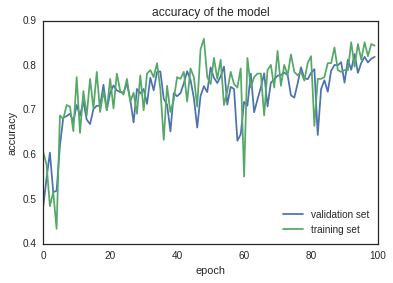

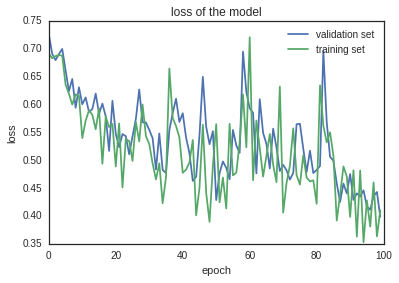

Found 929 images belonging to 2 classes.
Found 464 images belonging to 2 classes.
Epoch 1/100
320/300 [================================] - 17s - loss: 1.3478 - acc: 0.5203 - val_loss: 0.6857 - val_acc: 0.6289
Epoch 2/100
320/300 [================================] - 16s - loss: 0.6708 - acc: 0.6094 - val_loss: 0.6406 - val_acc: 0.6914
Epoch 3/100
321/300 [================================] - 16s - loss: 0.6371 - acc: 0.6480 - val_loss: 0.6921 - val_acc: 0.5703
Epoch 4/100
320/300 [================================] - 16s - loss: 0.7067 - acc: 0.5703 - val_loss: 0.6420 - val_acc: 0.7344
Epoch 5/100
320/300 [================================] - 16s - loss: 0.6843 - acc: 0.6016 - val_loss: 0.6331 - val_acc: 0.6562
Epoch 6/100
321/300 [================================] - 16s - loss: 0.7282 - acc: 0.6573 - val_loss: 0.7265 - val_acc: 0.5078
Epoch 7/100
320/300 [================================] - 16s - loss: 0.6617 - acc: 0.5812 - val_loss: 0.6785 - val_acc: 0.5117
Epoch 8/100
320/300 [========

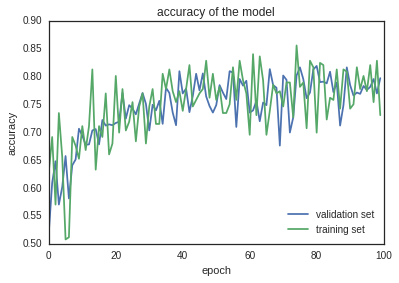

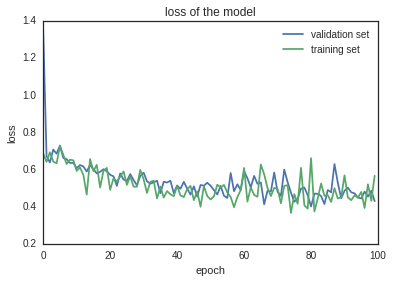

In [8]:
results = pandas.DataFrame(columns=['model_name','time_to_train','accuracy'])
dataset_path = configuration.dataset_train_test
model_path = configuration.model_path
optimizer_list = ['adam', 'Adagrad']
pic_dims = [configuration.model_height,configuration.model_width] # dimensions of input files
for layers in [1,2,3,4]:
    for optimizer in optimizer_list:
        model,model_name,time_to_train,acc = run_model(optimizer, nb_epocs, model_path, dataset_path,pic_dims,layers)
        results.loc[results.shape[0]+1,:] = [model_name,time_to_train,acc]
results.to_csv(dataset_path + "/" + 'Net_results.csv',sep=",",index=False)

Results are presented in terms of Accuracy and Loss for each of the optimizer attempted:


# Visualize Filters for the different conv layer

Now it is time to visualize how filters visualize 



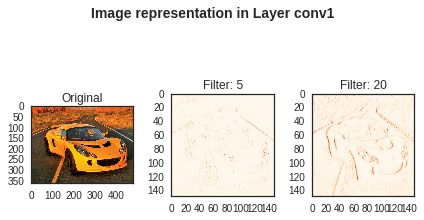

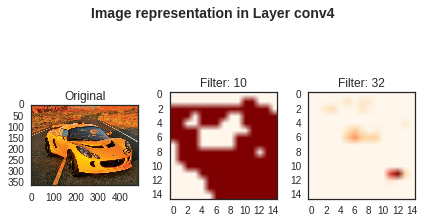

In [217]:
# load model architecture:
optimizer = 'Adagrad'
pic_dims = [configuration.model_height,configuration.model_width]
layers = 4 # for thisparticular example, let's run a network with 4 convs layers.

# load model:
model = models.build_model(optimizer,pic_dims,layers)

# load weights for the corresponding model
weights_path = configuration.model_path + "/" + 'Layers_{0}_{1}.h5'.format(layers,optimizer)
model.load_weights(weights_path)
  

path_to_image='Dataset_train_test/train/n04285008/n04285008_76.jpg'
layer_name='conv1'
filters = [5,20]
models.visualize_filters(path_to_image,layer_name,filters)

path_to_image='Dataset_train_test/train/n04285008/n04285008_76.jpg'
layer_name='conv4'
filters = [10,32]
models.visualize_filters(path_to_image,layer_name,filters)
